In [1]:
!ls data

'ls' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import numpy as np

def load_abs_surfs():
    abs_surfs = pd.read_excel('data/absSurfs.xlsx').set_index("Site")
    abs_surfs = abs_surfs.stack()
    abs_surfs.index.names = ["Site", "CLC"]
    idx = abs_surfs.index
    abs_surfs.index = abs_surfs.index.set_levels([idx.levels[0].to_series(), idx.levels[1].to_series().astype(int)])
    abs_surfs = pd.DataFrame({'surface': abs_surfs})
    return abs_surfs

def load_pesticides():
    pesticides = pd.read_excel('data/pesticides.xlsx').rename(columns={'importName': 'pesticide'})
    pesticides = pesticides.set_index("pesticide")
    pesticides["typeEN"] = pesticides["typeEN"].str.lower().str.replace("and", ",",regex=True).str.replace(" +", "",regex=True)
    pesticides["familyEN"] = pesticides["familyEN"].str.lower().str.replace(" +", ",",regex=True)
    return pesticides

def load_libelles():
    a = pd.read_excel('data/clc-nomenclature-c.xls', sheet_name="nomenclature_clc_1").rename(columns={'code_clc_1': "CLC"})
    b = pd.read_excel('data/clc-nomenclature-c.xls', sheet_name="nomenclature_clc_2").rename(columns={'code_clc_2': "CLC"})
    c = pd.read_excel('data/clc-nomenclature-c.xls', sheet_name="nomenclature_clc_3").rename(columns={'code_clc_3': "CLC"})
    libelles = pd.concat((a, b, c)).set_index("CLC")
    return libelles

def load_disthive():
    dist_beehive = pd.read_excel('data/distsOneSheet.xlsx').rename(columns={"classCLC": "CLC"}).set_index(["Site", "polyID", "CLC"])
    return dist_beehive

def load_periods(category):
    if category not in ["HM", "Pesticides"]:
        raise ValueError("cateogry can only be HM or Pesticides")
    
    all_data = []
    for year in ["2017", "2018", "2019", "2020"]:
        year_path = f"data/{year}/{category}"
        onlyfiles = [join(year_path, f) for f in listdir(year_path) if isfile(join(year_path, f)) and f.endswith(".xlsx") and not f.startswith('~')]
        for excel in onlyfiles:
            all_data.append(pd.read_excel(excel))
    df = pd.concat(all_data).rename(columns={"REF....SUBSTANCE": "Site", "PERIOD": "Period"})
    df = df.assign(
        Year=df["Period"].apply(lambda x: x.split('/')[0]),
        Quarter=df["Period"].apply(lambda x: x.split('/')[1])
    ).drop('Period', axis=1).set_index(['Site', 'Year', 'Quarter'])
    return df

def load_heavy_metal_lmr():
    lmr = pd.read_csv("data/LMR.txt", sep="\t").drop("Unnamed: 7", axis=1).stack().droplevel(0)
    lmr.index.name = "heavymetal"
    lmr = pd.DataFrame({'LMR': lmr})
    return lmr

def get_pesticides_flags(pesticides_periods, pesticide_cat, pesticides_family, pesticides, thresh=0):
    df = pesticides_periods
    base_index = df.index.names
    df = df.stack()
    # Pesticides
    df.index.names = base_index + ['pesticide']
    site_per_pesticide = df.reset_index().rename(columns={0: 'level'}).set_index('pesticide').merge(pesticides[['LMR']], left_index=True, right_index=True)
    site_per_pesticide = site_per_pesticide.assign(
        above_LMR=site_per_pesticide['level'] > site_per_pesticide['LMR'],
        present=site_per_pesticide['level'] > thresh
    )

    pesticide_cat_per_site = (site_per_pesticide.merge(pesticide_cat, left_index=True, right_index=True).groupby(base_index + ['pesticide_cat']).max())
    pesticide_cat_per_site = pesticide_cat_per_site.unstack()

    pesticide_fam_per_site = (site_per_pesticide.merge(pesticides_family, left_index=True, right_index=True).groupby(base_index + ['pesticide_family']).max())
    pesticide_fam_per_site = pesticide_fam_per_site.unstack()

    site_per_pesticide = site_per_pesticide.reset_index().set_index(base_index + ['pesticide'])

    pesticides_flags = pd.concat(
        [
            site_per_pesticide.unstack(),
            pesticide_cat_per_site,
            pesticide_fam_per_site,
        ],
        axis=1,
        keys=['pesticide', 'pesticide_cat','pesticide_family'],
    )
    return pesticides_flags

def get_heavymetal_flags(heavy_metals_periods, heavy_metal_lmr, thresh=0):
    df = heavy_metals_periods
    base_index = df.index.names
    df = df.stack()
    # Pesticides
    df.index.names = base_index + ["heavymetal"]
    df = df.reset_index().rename(columns={0: 'level'}).set_index('heavymetal')
    df = df.merge(heavy_metal_lmr, left_index=True, right_index=True).reset_index().set_index(base_index + ['heavymetal'])
    df = df.assign(
        above_LMR=df['level'] > df['LMR'],
        present=df['level'] > thresh
    )
    df = df.unstack()
    # Add column level
    df = pd.concat([df], axis=1, keys=['heavymetal'])
    return df

def get_phm_flags(phm, pesticide_cat, pesticides_family, pesticides, heavy_metal_lmr, thresh=0):
    df = pd.concat([
        get_pesticides_flags(phm['pesticide'], pesticide_cat, pesticides_family, pesticides, thresh=thresh),
        get_heavymetal_flags(phm['heavymetal'], heavy_metal_lmr, thresh=thresh),
    ], axis=1)
    # Drop LMR as it's not useful
    df = df.drop(['LMR'], axis=1, level=1)
    return df

def fill_phm_na(phm):
    # This will fill na in the following way:
    # First group by site and year. If a period is missing data for a year,
    # it will then inherit the mean for the periods of that year.
    # If all the periods for a year are nan, then the values will be grouped just by site,
    # and nan will be filled for these by the mean over all the periods of all the years for which there are values.
    # And if finally all values are nan, the value will be 0.
    # Changing mean() by ffill() or bfill() could be an alternative,
    # by setting the values of the previous period/year (ffill) or of the next period/year (bfill)
    new_pesticides = phm['pesticide'].groupby(['Site', 'Year'], sort=False).apply(lambda x: x.fillna(0))
    # Group just by site to replace values that are missing for all periods of a year by the mean of the periods of all years
    new_pesticides = new_pesticides.groupby(['Site'], sort=False).apply(lambda x: x.fillna(0))
    # Same for heavy metals
    new_heavymetal = phm['heavymetal'].groupby(['Site', 'Year'], sort=False).apply(lambda x: x.fillna(x.mean()))
    new_heavymetal = new_heavymetal.groupby(['Site'], sort=False).apply(lambda x: x.fillna(x.mean()).fillna(0))
    return phm.assign(
        pesticide=new_pesticides,
        heavymetal=new_heavymetal
    )

# Load all the data
heavy_metal_lmr = load_heavy_metal_lmr()
abs_surfs = load_abs_surfs() # Merged later
pesticides = load_pesticides()
libelles = load_libelles()
disthive = load_disthive() # Merged later
heavy_metal_periods = load_periods("HM")
# Merge chromium and chrome
heavy_metal_periods['Chromium'] = heavy_metal_periods['Chromium'] + heavy_metal_periods['Chrome']
heavy_metal_periods = heavy_metal_periods.drop(['Chrome'], axis=1)

pesticides_periods = load_periods("Pesticides")

# Start merging data together

# Average the distances to the hives
distsurf = disthive.groupby(['Site', 'CLC']).mean().merge(abs_surfs, left_index=True, right_index=True)

# Load historical data
phm = pd.concat(
    [pesticides_periods,
    heavy_metal_periods],
    axis=1,
    keys=['pesticide','heavymetal'],
)

phm = fill_phm_na(phm)

# Categorize pesticides
pesticides_family = pd.DataFrame({'pesticide_family': pesticides[["familyEN"]].fillna("UNKNOWN").apply(lambda r: r[0].split(','), axis=1).explode()})
pesticide_cat = pd.DataFrame({'pesticide_cat': pesticides[["typeEN"]].fillna("UNKNOWN").apply(lambda r: r[0].split(','), axis=1).explode()})

# Pesticide and heavy metals flags
phm_flags = get_phm_flags(phm, pesticide_cat, pesticides_family, pesticides, heavy_metal_lmr, thresh=0)

# We've now got basic features and basic things to predict.
# Next steps are to engineer these features, have a look at them and select a subset from the things to predict
features = distsurf.unstack().fillna(0)

# Contains the level, above_LMR, present for the pesticides, pesticides_category, pesticides_family, heavy_metal
to_predict = phm_flags

In [3]:
phm_flags

pesticide                                                 \
                        level                                                  
                    Aclonifen Aldrin Ametoctradin Anthraquinone Azoxystrobin   
Site   Year Quarter                                                            
B0012  2020 P1         0.0048    0.0          0.0           0.0          0.0   
            P2         0.0000    0.0          0.0           0.0          0.0   
            P3         0.0000    0.0          0.0           0.0          0.0   
            P4         0.0000    0.0          0.0           0.0          0.0   
B0017  2017 P1         0.0000    0.0          0.0           0.0          0.0   
...                       ...    ...          ...           ...          ...   
FE0001 2019 P3         0.0000    0.0          0.0           0.0          0.0   
            P4         0.0000    0.0          0.0           0.0          0.0   
       2020 P1         0.0000    0.0          0.0           0.0          0.0   
            P2         0.0000    0.0          0.0           0.0          0.0   
            P3         0.0000    0.0          0.0           0.0          0.0   

                                                               \
                                                                
                    Benalaxyl Benfluralin Benthiavalicarb.iso   
Site   Year Quarter                                             
B0012  2020 P1         0.0000         0.0                 0.0   
            P2         0.0000         0.0                 0.0   
            P3         0.0000         0.0                 0.0   
            P4         0.0000         0.0                 0.0   
B0017  2017 P1         0.0000         0.0                 0.0   
...                       ...         ...                 ...   
FE0001 2019 P3         0.0000         0.0                 0.0   
            P4         0.0000         0.0                 0.0   
       2020 P1         0.0000         0.0                 0.0   
            P2         0.0049         0.0                 0.0   
            P3         0.0000         0.0                 0.0   

                                               ... heavymetal                 \
                                               ...  above_LMR                  
                    Benzovindiflupyr Boscalid  ...    Arsenic Cadmium Copper   
Site   Year Quarter                            ...                             
B0012  2020 P1                   0.0    0.000  ...      False   False  False   
            P2                   0.0    0.000  ...      False   False  False   
            P3                   0.0    0.000  ...      False   False  False   
            P4                   0.0    0.000  ...      False   False  False   
B0017  2017 P1                   0.0    0.000  ...      False   False  False   
...                              ...      ...  ...        ...     ...    ...   
FE0001 2019 P3                   0.0    0.000  ...      False   False  False   
            P4                   0.0    0.000  ...      False   False  False   
       2020 P1                   0.0    0.009  ...      False   False  False   
            P2                   0.0    0.000  ...      False   False  False   
            P3                   0.0    0.000  ...      False   False  False   

                                                                          
                                   present                                
                      Lead Mercury Arsenic Cadmium Copper   Lead Mercury  
Site   Year Quarter                                                       
B0012  2020 P1       False   False    True    True   True   True   False  
            P2       False   False   False    True   True   True   False  
            P3       False   False    True    True   True   True   False  
            P4       False   False    True    True   True   True   False  
B0017  2017 P1       False   False   False

pesticide                                                           \
        present                                                            
      Aclonifen Aldrin Ametoctradin Anthraquinone Azoxystrobin Benalaxyl   
False       528    549          539           520          539       469   
True         22      1           11            30           11        81   

                                                                 ...  \
                                                                 ...   
      Benfluralin Benthiavalicarb.iso Benzovindiflupyr Boscalid  ...   
False         548                 549              548      531  ...   
True            2                   1                2       19  ...   

      pesticide_family                                                       \
               present                                                        
              triazole triazolinthione triazolopyrimidine unclassified urea   
False              489             534                539          530  548   
True                61              16                 11           20    2   

      heavymetal                              
         present                              
         Arsenic Cadmium Copper Lead Mercury  
False        213     0.0     13   84     527  
True         337   550.0    537  466      23  

[2 rows x 199 columns]

,heavymetal,pesticide,pesticide_cat,pesticide_family
,present,present,present,present
False,837,61828,3965,38679
True,1913,872,435,921


pesticide                                                           \
      above_LMR                                                            
      Aclonifen Aldrin Ametoctradin Anthraquinone Azoxystrobin Benalaxyl   
False     550.0  550.0          548         550.0          545       532   
True        0.0    0.0            2           0.0            5        18   

                                                                 ...  \
                                                                 ...   
      Benfluralin Benthiavalicarb.iso Benzovindiflupyr Boscalid  ...   
False       550.0               550.0            550.0      541  ...   
True          0.0                 0.0              0.0        9  ...   

      pesticide_family                                                       \
             above_LMR                                                        
              triazole triazolinthione triazolopyrimidine unclassified urea   
False              539           550.0                548          547  549   
True                11             0.0                  2            3    1   

      heavymetal                              
       above_LMR                              
         Arsenic Cadmium Copper Lead Mercury  
False        549     546    549  544   550.0  
True           1       4      1    6     0.0  

[2 rows x 199 columns]

,heavymetal,pesticide,pesticide_cat,pesticide_family
,above_LMR,above_LMR,above_LMR,above_LMR
False,2738,62528,4290,39431
True,12,172,110,169


Text(0.5, 1.0, 'Heavy metal above_LMR')

<Figure size 432x288 with 0 Axes>

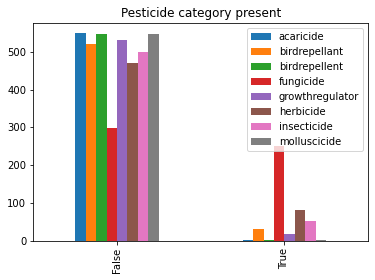

<Figure size 432x288 with 0 Axes>

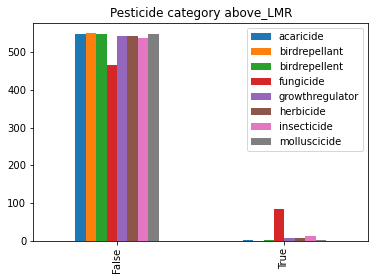

<Figure size 432x288 with 0 Axes>

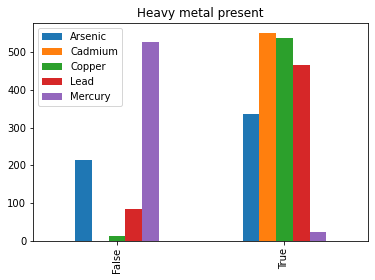

<Figure size 432x288 with 0 Axes>

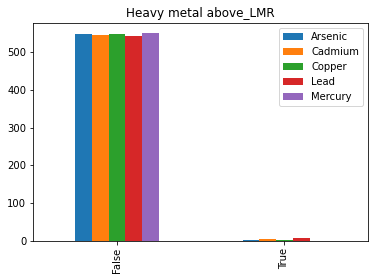

In [4]:
import matplotlib.pyplot as plt
# Look at counts for each category. As you can see, quite unbalanced with a threshold of 0...
idx = pd.IndexSlice
display(phm_flags.loc[:, idx[:, 'present', :]].apply(pd.Series.value_counts).fillna(0))
plt.figure()
phm_flags.loc[:, idx['pesticide_cat', 'present', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Pesticide category present")
display(phm_flags.loc[:, idx[:, 'present', :]].stack().apply(pd.Series.value_counts).fillna(0))
display(phm_flags.loc[:, idx[:, 'above_LMR', :]].apply(pd.Series.value_counts).fillna(0))
plt.figure()
phm_flags.loc[:, idx['pesticide_cat', 'above_LMR', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Pesticide category above_LMR")
display(phm_flags.loc[:, idx[:, 'above_LMR', :]].stack().apply(pd.Series.value_counts).fillna(0))
plt.figure()
phm_flags.loc[:, idx['heavymetal', 'present', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Heavy metal present")
plt.figure()
phm_flags.loc[:, idx['heavymetal', 'above_LMR', :]].apply(pd.Series.value_counts).droplevel([0, 1], axis=1).fillna(0).plot(kind="bar")
plt.title("Heavy metal above_LMR")


In [5]:
# Expand the features artifically
def set_year_and_quarter(df, year, quarter):
    new_df = {}
    new_df[year] = df
    df = pd.concat(new_df, names=['Year']).reorder_levels(['Site', 'Year'])
    new_df = {}
    new_df[quarter] = df
    df = pd.concat(new_df, names=['Quarter']).reorder_levels(['Site', 'Year', 'Quarter'])
    return df

def create_history_for_features(features, year, quarter, percent_noise=0.2):
    # Just fetching from a random distribution with some noise here.
    df = features.apply(lambda x: x*np.random.uniform(1-percent_noise, 1+percent_noise, len(x)))
    df = set_year_and_quarter(df, year, quarter)
    return df

def create_fictive_history(features, phm, validation_year_period, percent_noise=0.2):
    # This is generating too much data as not every site has 4 years and 4 periods.
    # But the merge later will take care of that.
    years = list(phm.index.get_level_values('Year').unique())
    quarters = list(phm.index.get_level_values('Quarter').unique())
    all_data = []
    for year in years:
        for quarter in quarters:
            if (year, quarter) in validation_year_period:
                # Use real values
                new_features = set_year_and_quarter(features, year, quarter).assign(DataType="validation")
            else:
                # Use fictive values
                new_features = create_history_for_features(features, year, quarter, percent_noise=percent_noise).assign(DataType="training")
            new_features.reset_index().set_index(new_features.index.names + ['DataType'])
            all_data.append(new_features)
    return pd.concat(all_data, axis=0)

validation_year_period = [("2020", "P1"), ("2020", "P2"), ("2020", "P3"), ("2020", "P4")]
fictive = create_fictive_history(features, phm_flags, validation_year_period)
fictive

dist                                             \
CLC                          111         112          121          122  123   
Site   Year Quarter                                                           
B0012  2020 P1       1020.033273  564.609800   117.220148     0.000000  0.0   
B0017  2020 P1          0.000000  230.733942  1457.209438     0.000000  0.0   
B0019  2020 P1          0.000000    0.000000     0.000000     0.000000  0.0   
B0021  2020 P1          0.000000    0.000000     0.000000     0.000000  0.0   
B0023  2020 P1          0.000000    0.000000     0.000000     0.000000  0.0   
...                          ...         ...          ...          ...  ...   
F0069  2019 P4          0.000000  846.432698     0.000000     0.000000  0.0   
F0071  2019 P4          0.000000    0.000000   845.191873     0.000000  0.0   
F0073  2019 P4          0.000000    0.000000     0.000000     0.000000  0.0   
F0075  2019 P4          0.000000  758.680979   398.080281  1449.563357  0.0   
FE0001 2019 P4          0.000000    0.000000     0.000000     0.000000  0.0   

                                                              ...  \
CLC                  124          131  133  141          142  ...   
Site   Year Quarter                                           ...   
B0012  2020 P1       0.0     0.000000  0.0  0.0     0.000000  ...   
B0017  2020 P1       0.0     0.000000  0.0  0.0     0.000000  ...   
B0019  2020 P1       0.0     0.000000  0.0  0.0     0.000000  ...   
B0021  2020 P1       0.0     0.000000  0.0  0.0     0.000000  ...   
B0023  2020 P1       0.0     0.000000  0.0  0.0  1223.368654  ...   
...                  ...          ...  ...  ...          ...  ...   
F0069  2019 P4       0.0     0.000000  0.0  0.0  1151.423862  ...   
F0071  2019 P4       0.0  1011.173176  0.0  0.0     0.000000  ...   
F0073  2019 P4       0.0     0.000000  0.0  0.0     0.000000  ...   
F0075  2019 P4       0.0     0.000000  0.0  0.0     0.000000  ...   
FE0001 2019 P4       0.0     0.000000  0.0  0.0     0.000000  ...   

                          surface                                             \
CLC                           313  322           324  331           412  423   
Site   Year Quarter                                                            
B0012  2020 P1       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
B0017  2020 P1       1.871540e+06  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
B0019  2020 P1       1.330174e+06  0.0  0.000000e+00  0.0  3.786370e+05  0.0   
B0021  2020 P1       3.620488e+06  0.0  0.000000e+00  0.0  9.421463e+05  0.0   
B0023  2020 P1       6.865176e+04  0.0  6.979889e+05  0.0  1.809062e+06  0.0   
...                           ...  ...           ...  ...           ...  ...   
F0069  2019 P4       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
F0071  2019 P4       0.000000e+00  0.0  7.977755e+05  0.0  0.000000e+00  0.0   
F0073  2019 P4       8.001580e+03  0.0  1.392468e+06  0.0  0.000000e+00  0.0   
F0075  2019 P4       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   
FE0001 2019 P4       0.000000e+00  0.0  0.000000e+00  0.0  0.000000e+00  0.0   

                                                          DataType  
CLC                            511            512  523              
Site   Year Quarter                                                 
B0012  2020 P1       486328.326111       0.000000  0.0  validation  
B0017  2020 P1            0.000000       0.000000  0.0  validation  
B0019  2020 P1            0.000000       0.000000  0.0  validation  
B0021  2020 P1            0.000000       0.000000  0.0  validation  
B0023  2020 P1            0.000000       0.000000  0.0  validation  
...                            ...            ...  ...         ...  
F0069  2019 P4            0.000000       0.000000  0.0    training  
F0071  2019 P4            0.000000  579370.404881  0.0    training  
F0073  2019 P4            0.000000       0.000000  0.0    training  
F0075

In [6]:
def get_full_dataset(fictive, phm_flags):
    # Add column level
    fictive_p = pd.concat([fictive], axis=1, keys=['features'])
    # Twice because the number of levels for features and target must be equal to be able to merge them
    fictive_p = pd.concat([fictive_p], axis=1, keys=['features'])
    target_p = pd.concat([phm_flags], axis=1, keys=['target'])
    # This will remove the (year, quarter) pairs from the fictive dataset that don't actually exist as measurements for a site
    full_dataset = fictive_p.merge(target_p, left_index=True, right_index=True)
    # Full dataset containing the features and the targets.
    full_dataset = full_dataset.reset_index().set_index(['Site','Year', 'Quarter', ('features', 'features', 'DataType')])
    full_dataset.index.names = full_dataset.index.names[:-1] + ['DataType']
    return full_dataset

full_dataset = get_full_dataset(fictive, phm_flags)
full_dataset

C:\Users\Guillaume\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2923: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
C:\Users\Guillaume\anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


features                            \
                                   features                             
                                       dist                             
CLC                                     111          112          121   
Site   Year Quarter DataType                                            
B0012  2020 P1      validation  1020.033273   564.609800   117.220148   
B0017  2020 P1      validation     0.000000   230.733942  1457.209438   
B0019  2020 P1      validation     0.000000     0.000000     0.000000   
B0021  2020 P1      validation     0.000000     0.000000     0.000000   
B0023  2020 P1      validation     0.000000     0.000000     0.000000   
...                                     ...          ...          ...   
F0035  2019 P4      training       0.000000     0.000000     0.000000   
F0039  2019 P4      training       0.000000  1474.700701   852.286874   
F0041  2019 P4      training       0.000000     0.000000     0.000000   
F0043  2019 P4      training       0.000000  1021.024057   929.026557   
FE0001 2019 P4      training       0.000000     0.000000     0.000000   

                                                                              \
                                                                               
                                                                               
CLC                                     122  123        124  131         133   
Site   Year Quarter DataType                                                   
B0012  2020 P1      validation     0.000000  0.0    0.00000  0.0     0.00000   
B0017  2020 P1      validation     0.000000  0.0    0.00000  0.0     0.00000   
B0019  2020 P1      validation     0.000000  0.0    0.00000  0.0     0.00000   
B0021  2020 P1      validation     0.000000  0.0    0.00000  0.0     0.00000   
B0023  2020 P1      validation     0.000000  0.0    0.00000  0.0     0.00000   
...                                     ...  ...        ...  ...         ...   
F0035  2019 P4      training       0.000000  0.0    0.00000  0.0     0.00000   
F0039  2019 P4      training    1097.488330  0.0    0.00000  0.0  1120.95478   
F0041  2019 P4      training     243.783362  0.0    0.00000  0.0     0.00000   
F0043  2019 P4      training       0.000000  0.0  631.39629  0.0     0.00000   
FE0001 2019 P4      training       0.000000  0.0    0.00000  0.0     0.00000   

                                                         ...     target  \
                                                         ... heavymetal   
                                                         ...  above_LMR   
CLC                                    141          142  ...    Arsenic   
Site   Year Quarter DataType                             ...              
B0012  2020 P1      validation    0.000000     0.000000  ...      False   
B0017  2020 P1      validation    0.000000     0.000000  ...      False   
B0019  2020 P1      validation    0.000000     0.000000  ...      False   
B0021  2020 P1      validation    0.000000     0.000000  ...      False   
B0023  2020 P1      validation    0.000000  1223.368654  ...      False   
...                                    ...          ...  ...        ...   
F0035  2019 P4      training      0.000000     0.000000  ...      False   
F0039  2019 P4      training      0.000000     0.000000  ...      False   
F0041  2019 P4      training    668.567382  1389.008508  ...      False   
F0043  2019 P4      training      0.000000   859.736359  ...      False   
FE0001 2019 P4      training      0.000000     0.000000  ...      False   

                                                                              \
                                                                               
                                                             present           
CLC                            Cadmium Copper   Lead Mercury Arsenic Cadmium   
Site   Year Quarter DataType                                    

In [7]:
# Just a quick dirty test.
sub_target = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['above_LMR'] and c[3] == 'Lead']]

idx = pd.IndexSlice
X_train = full_dataset["features"].loc[:, :, :, 'training']
X_test = full_dataset["features"].loc[:, :, :, 'validation']
Y_train = sub_target.loc[:, :, :, 'training']
Y_test = sub_target.loc[:, :, :, 'validation']

from sklearn.svm import SVC
from sklearn.metrics import classification_report
clf = SVC()
clf.fit(X_train, Y_train)

print(classification_report(clf.predict(X_test), Y_test))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99       194
        True       0.00      0.00      0.00         0

    accuracy                           0.98       194
   macro avg       0.50      0.49      0.50       194
weighted avg       1.00      0.98      0.99       194



C:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### PCA

In [8]:
X_train = full_dataset["features"].loc[:, :, :, 'training']
X_test = full_dataset["features"].loc[:, :, :, 'validation']

In [9]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
from sklearn.decomposition import PCA

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [11]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([1.51482355e-01, 8.21644020e-02, 7.29747063e-02, 6.57034740e-02,
       5.94657176e-02, 4.75871770e-02, 4.40971399e-02, 4.21491073e-02,
       4.06836836e-02, 3.84175175e-02, 3.49437282e-02, 3.22213000e-02,
       2.97574172e-02, 2.83137355e-02, 2.43181173e-02, 2.10310091e-02,
       2.02598671e-02, 1.85916074e-02, 1.67789017e-02, 1.53698257e-02,
       1.31365944e-02, 1.22591256e-02, 1.08353048e-02, 9.51655640e-03,
       9.08290270e-03, 8.67732925e-03, 7.97923497e-03, 6.82685523e-03,
       5.25324866e-03, 4.84367823e-03, 4.23696170e-03, 3.32531182e-03,
       3.02832758e-03, 2.64700989e-03, 2.33549051e-03, 2.00730395e-03,
       1.54372093e-03, 1.41586881e-03, 1.14889894e-03, 6.29542681e-04,
       4.59464657e-04, 4.13868619e-04, 3.05248980e-04, 2.87137504e-04,
       2.68137539e-04, 2.43055466e-04, 2.12845423e-04, 1.87430305e-04,
       1.66975675e-04, 1.59814770e-04, 1.58166956e-04, 9.77973584e-05])

<function matplotlib.pyplot.show(close=None, block=None)>

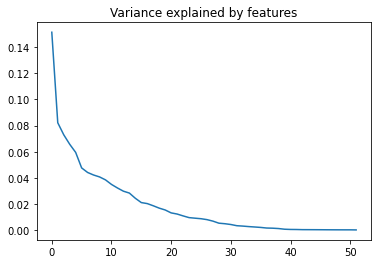

In [12]:
plt.plot(explained_variance)
plt.title("Variance explained by features")
plt.show

In [13]:
explained_variance[0:30].sum()

0.9747216199421783

#### Lazy processing - Heavy metal/above_LMR/Lead

In [14]:
sub_target = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['above_LMR'] and c[3] == 'Lead']]

idx = pd.IndexSlice
X_train = full_dataset["features"].loc[:, :, :, 'training']
X_test = full_dataset["features"].loc[:, :, :, 'validation']
y_train = sub_target.loc[:, :, :, 'training']
y_test = sub_target.loc[:, :, :, 'validation']

In [15]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=42, sampling_strategy=0.3, k_neighbors=2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [16]:
y_train.target.heavymetal.above_LMR.Lead.value_counts()

False    353
True     105
Name: Lead, dtype: int64

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(n_components=35)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [18]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)

C:\Users\Guillaume\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
100%|██████████| 30/30 [00:00<00:00, 36.06it/s]

[14:05:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [19]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.98,0.66,0.66,0.98,0.11
BaggingClassifier,0.98,0.66,0.66,0.98,0.03
XGBClassifier,0.98,0.66,0.66,0.98,0.07
SVC,0.98,0.66,0.66,0.98,0.01
SGDClassifier,0.98,0.66,0.66,0.98,0.01
RidgeClassifierCV,0.98,0.66,0.66,0.98,0.01
RidgeClassifier,0.98,0.66,0.66,0.98,0.01
RandomForestClassifier,0.98,0.66,0.66,0.98,0.14
Perceptron,0.98,0.66,0.66,0.98,0.01


In [20]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=6)

neigh.fit(X_train, y_train)

y_pred_knn = neigh.predict(X_test)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99       191
        True       0.33      0.33      0.33         3

    accuracy                           0.98       194
   macro avg       0.66      0.66      0.66       194
weighted avg       0.98      0.98      0.98       194



#### Cross validation

In [22]:
sub_target = full_dataset[[c for c in full_dataset.columns if c[0] == 'target' and c[1] in ['heavymetal'] and c[2] in ['above_LMR'] and c[3] == 'Lead']]

idx = pd.IndexSlice
X_cv = full_dataset["features"]
y_cv = sub_target

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

sm = SMOTE(random_state=42, sampling_strategy=0.2, k_neighbors=2)
X_cv, y_cv = sm.fit_resample(X_cv, y_cv)

clf_forest=RandomForestClassifier(n_estimators=100, random_state=42)
scores_randfor = cross_val_score(clf_forest, X_cv, y_cv, cv=10, scoring="f1")
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_randfor.mean(), scores_randfor.std()))

0.98 accuracy with a standard deviation of 0.03


In [24]:
scores_randfor

array([0.90909091, 0.95652174, 0.95238095, 0.95238095, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])